In [1]:
# Importing Libarries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
import itertools
from collections import Counter
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Loading Dataset into Datafarme
df_fraud = pd.read_csv("Fraud.csv")
# Print First 5 rows of Dataset
df_fraud.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
# Descriptive Statistcs of Each Column
df_fraud.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [4]:
# Finding exact count of missing Vlues in each Column
df_fraud.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

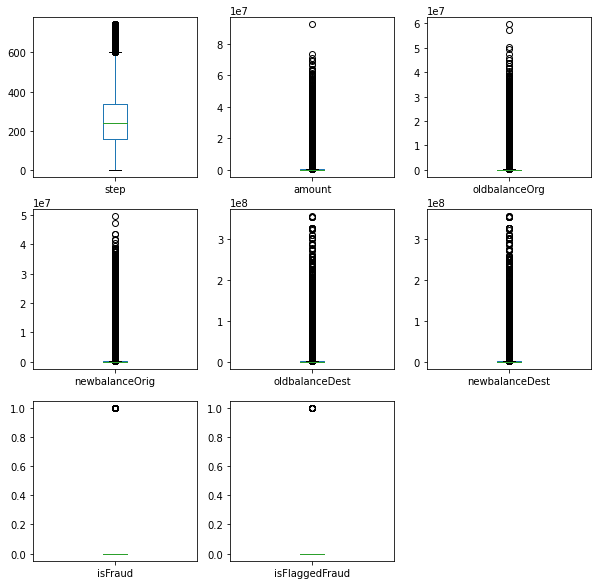

In [5]:
# Detecting Outliers in Each Column
df_fraud.plot(kind="box", subplots=True, layout=(3,3),  figsize=(10,10))
plt.show()

<AxesSubplot:>

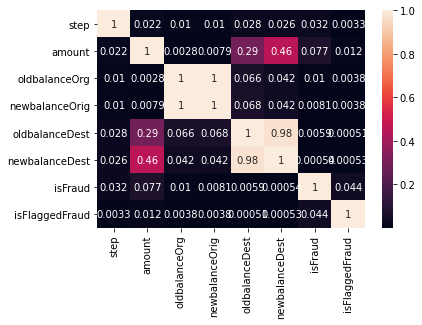

In [6]:
# Decting Collinearity Using Heatmap
sns.heatmap(df_fraud.corr().abs(),annot=True)

In [7]:
# Creating fraudulent dataframe
fraud = df_fraud[df_fraud['isFraud'] == 1]
# Creating non fraudulent dataframe
non_fraud = df_fraud[df_fraud['isFraud'] == 0]
# Percentage of Fraud vs Non Fraud
fraud_percent = (fraud / (fraud + non_fraud)) * 100
non_fraud_percent = (non_fraud / (fraud + non_fraud)) * 100

In [8]:
# Checking the frequency of frauds before moving forward
df_fraud.isFraud.value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [9]:
# Checking the frequency of frauds before moving forward
df_fraud.isFlaggedFraud.value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

<AxesSubplot:xlabel='isFraud', ylabel='count'>

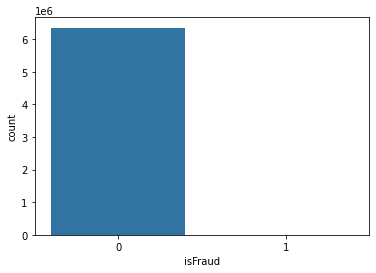

In [10]:
# Target Variable is highly Imbalanced.
sns.countplot(x=df_fraud.isFraud)

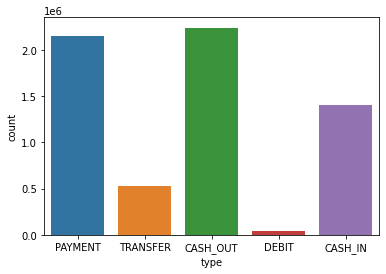

In [11]:
sns.countplot(df_fraud['type'])
plt.show()

<AxesSubplot:xlabel='amount', ylabel='Density'>

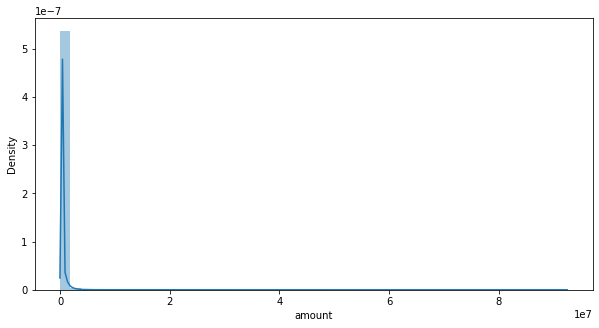

In [12]:
plt.figure(figsize=(10, 5))
sns.distplot(df_fraud.amount)

In [13]:
#creating a copy of original dataset to train and test models
new_df=df_fraud.copy()
new_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [14]:
# Checking how many attributes are dtype: object
newlist = new_df.select_dtypes(include = "object").columns
print (newlist)

Index(['type', 'nameOrig', 'nameDest'], dtype='object')


In [15]:
# Using label Encoder 
le = LabelEncoder()
for dataa in newlist:
    new_df[dataa] = le.fit_transform(new_df[dataa].astype(str))
print(new_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            int64  
 2   amount          float64
 3   nameOrig        int64  
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        int64  
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(6)
memory usage: 534.0 MB
None


In [16]:
new_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,757869,170136.0,160296.36,1662094,0.0,0.0,0,0
1,1,3,1864.28,2188998,21249.0,19384.72,1733924,0.0,0.0,0,0
2,1,4,181.00,1002156,181.0,0.00,439685,0.0,0.0,1,0
3,1,1,181.00,5828262,181.0,0.00,391696,21182.0,0.0,1,0
4,1,3,11668.14,3445981,41554.0,29885.86,828919,0.0,0.0,0,0


In [17]:
# Using library for VIF (VARIANCE INFLATION FACTOR)
def calc_vif(df_fraud):
   # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = df_fraud.columns
    vif["VIF"] = [variance_inflation_factor(df_fraud.values, i) for i in range(df_fraud.shape[1])]
    return(vif)
calc_vif(new_df)

,variables,VIF
0,step,2.791610
1,type,4.467405
2,amount,4.149312
3,nameOrig,2.764234
4,oldbalanceOrg,576.803777
5,newbalanceOrig,582.709128
6,nameDest,3.300975
7,oldbalanceDest,73.349937
8,newbalanceDest,85.005614
9,isFraud,1.195305


In [18]:
new_df['Actual_amount_orig'] = new_df.apply(lambda x: x['oldbalanceOrg'] - x['newbalanceOrig'],axis=1)
new_df['Actual_amount_dest'] = new_df.apply(lambda x: x['oldbalanceDest'] - x['newbalanceDest'],axis=1)
new_df['TransactionPath'] = new_df.apply(lambda x: x['nameOrig'] + x['nameDest'],axis=1)

#Dropping columns
new_df = new_df.drop(['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','step','nameOrig','nameDest'],axis=1)

calc_vif(new_df)

,variables,VIF
0,type,2.687803
1,amount,3.818902
2,isFraud,1.184479
3,isFlaggedFraud,1.002546
4,Actual_amount_orig,1.307910
5,Actual_amount_dest,3.754335
6,TransactionPath,2.677167


<AxesSubplot:>

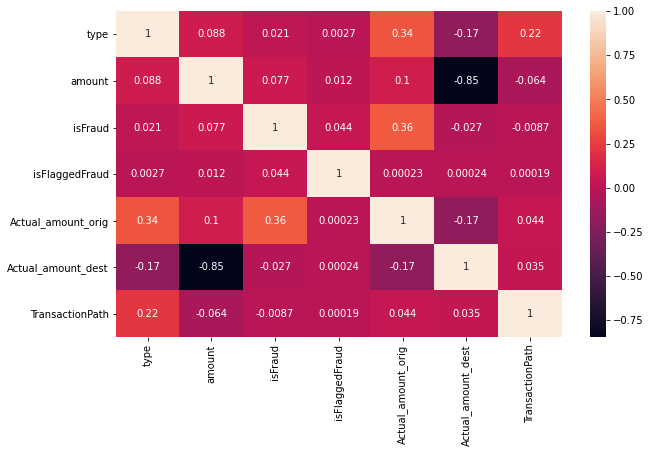

In [19]:
# checking New Heatmap for Collinearity
corr=new_df.corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr,annot=True)

In [20]:
# Normalizing Scaling Count
# Perform Scaling
scaler = StandardScaler()
new_df["NormalizedAmount"] = scaler.fit_transform(new_df["amount"].values.reshape(-1, 1))
new_df.drop(["amount"], inplace= True, axis= 1)

Y = new_df["isFraud"]
X = new_df.drop(["isFraud"], axis= 1)

In [21]:
# Splitting the Data
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, random_state=42, test_size=0.25, shuffle=True)
print(xtrain.shape, ytrain.shape)
print(xtest.shape, ytest.shape)

(4771965, 6) (4771965,)
(1590655, 6) (1590655,)


In [22]:
# Model Building
# Decision Tree 

In [23]:
# DECISION TREE
decision_tree = DecisionTreeClassifier()
decision_tree.fit(xtrain, ytrain)

Y_pred_dt = decision_tree.predict(xtest)
decision_tree_score = decision_tree.score(xtest, ytest) * 100

In [24]:
# RANDOM FOREST

random_forest = RandomForestClassifier(n_estimators= 100)
random_forest.fit(xtrain, ytrain)

Y_pred_rf = random_forest.predict(xtest)
random_forest_score = random_forest.score(xtest, ytest) * 100

In [25]:
# Evaluation
print("Decision Tree Score: ", decision_tree_score)
print("Random Forest Score: ", random_forest_score)

Decision Tree Score:  99.92342777032103
Random Forest Score:  99.95932493218203


In [27]:
#  Confusion Matrix - Decision Tree

print("TP,FP,TN,FN - Decision Tree")
tn, fp, fn, tp = confusion_matrix(ytest, Y_pred_dt).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

print("---------------------------------")

#  Confusion Matrix - Random Forest

print("TP,FP,TN,FN - Random Forest")
tn, fp, fn, tp = confusion_matrix(ytest, Y_pred_rf).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

TP,FP,TN,FN - Decision Tree
True Positives: 1457
False Positives: 630
True Negatives: 1587980
False Negatives: 588
---------------------------------
TP,FP,TN,FN - Random Forest
True Positives: 1450
False Positives: 52
True Negatives: 1588558
False Negatives: 595


In [28]:
# confusion matrix - DT

confusion_matrix_dt = confusion_matrix(ytest, Y_pred_dt.round())
print("Confusion Matrix - Decision Tree")
print(confusion_matrix_dt,)

print("---------------------------------")

# confusion matrix - RF

confusion_matrix_rf = confusion_matrix(ytest, Y_pred_rf.round())
print("Confusion Matrix - Random Forest")
print(confusion_matrix_rf)

Confusion Matrix - Decision Tree
[[1587980     630]
 [    588    1457]]
---------------------------------
Confusion Matrix - Random Forest
[[1588558      52]
 [    595    1450]]


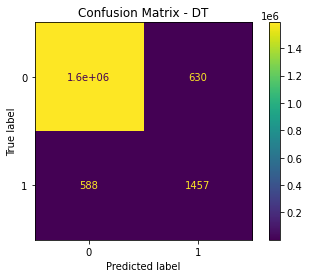

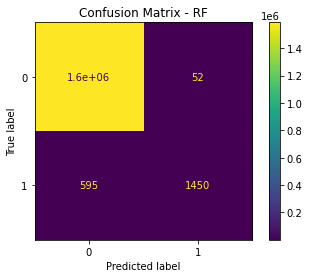

In [29]:
# Visualizing Confusion Matrix

# visualising confusion matrix - DT

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_dt)
disp.plot()
plt.title('Confusion Matrix - DT')
plt.show()

# visualising confusion matrix - RF
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_rf)
disp.plot()
plt.title('Confusion Matrix - RF')
plt.show()

In [ ]:
# Visualizing ROC Curve for both RandomForest and DecisionTree

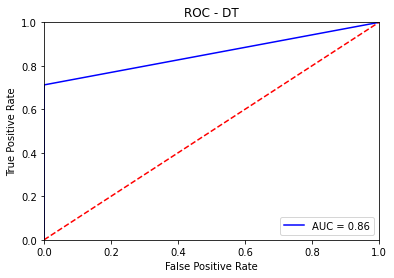

In [31]:
# AUC ROC - DT
# calculate the fpr and tpr for all thresholds of the classification

fpr, tpr, threshold = metrics.roc_curve(ytest, Y_pred_dt)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC - DT')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

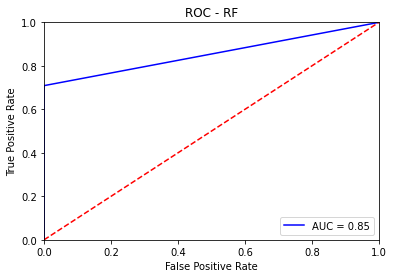

In [32]:
# AUC ROC - RF
# calculate the fpr and tpr for all thresholds of the classification

fpr, tpr, threshold = metrics.roc_curve(ytest, Y_pred_rf)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC - RF')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:

# CONCLUSION


# Describe your fraud detection model in elaboration.
We want to make a classifier, where the target variable is whether a given transaction is fraudulent or not. 
The model will produce a probability score at the transaction level for that particular transaction being fraudulent, and if it is above a certain threshold then it will predict a 1 for fraud and 0 for non-fraud. 
The label, fraud or not, can be identified from looking at which past transactions were actually refunded or disputed.


# How did you select variables to be included in the model?
To build our model, we split the data into a training and testing set. 
Regardless of the classifier chosen (SVM, Logistic Regression, etc.)

To evaluate our classifier, we can look at precision and recall:

Precision is defined as the number of true positives divided by the sum of true positives and false positives. 
A true positive, for this business context, is when the model predicts a fraudulent transaction and the transaction was actually fraudulent. 
A false positive is when the model predicts a fraudulent transaction but the transaction was actually not fraudulent. There is a cost to a false positive: the business will lose out on the particular transaction. Therefore, it is important to maximize precision, since the higher it is, the fewer false positives there are.

Recall is defined as the number of true positives divided by the sum of true positives and false negatives. 
A false negative is when the model predicts that the transaction is not fraudulent, but the transaction actually turned out to be fraudulent. 
The cost of a false negative is the cost of the transaction itself. Therefore, it is important to maximize recall, since the higher it is, the fewer false negatives there are.



# Demonstrate the performance of the model by using best set of tools.
We have seen that Accuracy of both Random Forest and Decision Tree is equal, although teh precision of Random Forest is more. 

In a fraud detection model, 
Precision is highly important because rather than predicting normal transactions correctly we want Fraud transactions to be predicted correctly and Legit to be left off.
If either of the 2 reasons are not fulfiiled we may catch the innocent and leave the culprit.
This is also one of the reason why Random Forest and Decision Tree are used unstead of other algorithms.


Also the reason I have chosen this model is because of highly unbalanced dataset (Legit: Fraud :: 99.87:0.13). Random forest makes multiple decision trees which makes it easier (although time taking) for model to understand the data in a simpler way since Decision Tree makes decisions in a boolean way.


Models like XGBoost, Bagging, ANN, and Logistic Regression may give good accuracy but they won't give good precision and recall values.




# What are the key factors that predict fraudulent customer?

The source of request is secured or not ?
Is the name of organisation asking for money is legit or not ?
Transaction history of vendors.

# Do these factors make sense? If yes, How? If not, How not?
Yeah 



# What kind of prevention should be adopted while company update its infrastructure?

Use smart vertified apps only.
Browse through secured websites.
Use secured internet connections (USE VPN).
Keep your mobile and laptop security updated.
Don't respond to unsolicited calls/SMS(s/E-mails.
If you feel like you have been tricked or security compromised, contact your bank immidiately.


# Assuming these actions have been implemented, how would you determine if they work?

Bank sending E-statements.
Customers keeping a check of their account activity.
Always keep a log of your payments.